In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd
from scipy.io import loadmat
import scipy.io as sio   

# load data
matfn = 'trajectories_train.mat'
data = sio.loadmat(matfn)  


In [63]:
# make all data be the same size 

def padding(data):
    max_len = max([ i.shape[-1] for i in data['xtrain'][0]])

    trans_data = []
    for i in data['xtrain'][0]:
        i = i.reshape(-1,3)
        len_ = i.shape[0]

        # padding for shorter data.
        if max_len - len_:
            trans_data.append(np.vstack(( i, [i[-1]] * (max_len- len_)))) 
        else:
            trans_data.append(i)
    return np.array(trans_data)

a = padding(data)
print(len(a))
print(len(a[0]))

1429
205


In [64]:
# load data
xtrain = padding(data)
ytrain = data['ytrain']

print(xtrain.shape)
print

(1429, 205, 3)


In [65]:
a = xtrain[1428:] + xtrain[:0]
print(a.shape)
xtrain.shape

(0, 205, 3)


(1429, 205, 3)

In [84]:
# get next minibatch
def get_next(i, batch_size):
    if i+batch_size < xtrain.shape[0]:
        end = i + batch_size
        x = x_[i:end]
        y = ytrain[0][i:end]
    else:
        end = xtrain.shape[0] - i + batch_size
        x = x_[i:] + x_[:end]
        y = ytrain[0][i:] + ytrain[0][:end]
    return x, y, i

# TODO: use np.hsplit???
def sperate_x_y_z(data):
    x = []
    y = []
    z = []
    for i in data:
        temp_x = []
        temp_y = []
        temp_z = []
        for j in i:
            temp_x.append(j[0])
            temp_y.append(j[1])
            temp_z.append(j[2])
        x.append(temp_x)
        y.append(temp_y)
        z.append(temp_z)
    return np.array(x), np.array(y), np.array(z)
print(xtrain.shape)
x_, y_, z_ = sperate_x_y_z(xtrain)
print(x.shape)

pp, ss, ii = get_next(2, 100)
print(i)
print(ss)

(1429, 205, 3)
(?, 205)
0
[17 16  2 14 13 17  1  5 18 15  9 16  4  9 10 14  4  5 12 20 11  8 17  5 20
 16  5 12 12  5  4 13  3  6 13 17 15 17 18  8  4 20 12 19  6  8 20  9 14  6
  1  4 17  4  5 15  5 14  7 11 10 16  2 15 11  7 13 19  6 15  6  1 10 10  8
 20 15 12  7 20 16 14 16  1  5 15  3 17  5  5  6 12  2 19 16 13  5  7 13  5]


In [87]:
# bayesian netword model
N = 100   # number of images in a minibatch.
D = max([ i.shape[-1] for i in data['xtrain'][0]])  # number of features.
K = 20    # number of classes.

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(xtrain.shape[0]) / N})

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
i = 0
for _ in range(inference.n_iter):
    X_batch, Y_batch, i = get_next(i, N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch-1})
    inference.print_progress(info_dict)



5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 520.611


In [92]:
x_.

(1429, 205)

In [101]:
X_test, Y_test, ii = get_next(2, 100)
X_test = X_test.astype(np.float32)

# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    print(_, end=" ")
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 

KeyboardInterrupt: 

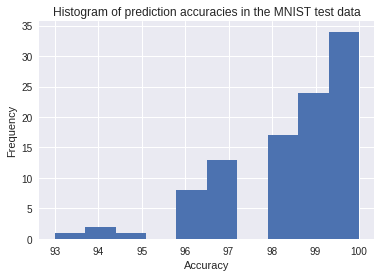

In [98]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test-1).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")